In [234]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt, dates
import datetime
from sklearn import linear_model
from scipy.spatial.distance import cosine
from scipy.optimize import curve_fit

sb.set_context("poster")
plt.style.use('ggplot')
%matplotlib inline

In [4]:
def get_stock(stock_ticker):
    stock = yf.Ticker(stock_ticker)
    #periods = “1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
    stock_dic = {}
    stock_dic['ticker'] = stock_ticker
    stock_dic['1d'] = stock.history(period='1d', interval='1m', actions=False)
    stock_dic['5d'] = stock.history(period='5d', interval='1d', actions=False)
    stock_dic['1mo'] = stock.history(period='1mo', interval='1d', actions=False)
    stock_dic['6mo'] = stock.history(period='6mo', interval='1d', actions=False)
    
    return stock_dic

In [266]:
def get_fits(df, period):
    df_copy = df.copy()
    if period == '1d':
        df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).seconds
    else:
        df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).days
    x = df_copy.loc[:, 'period_from_start'].T
    y = df_copy.loc[:, 'Close']
    polyfit_close = np.polyfit(x, y, 1)
    function = np.poly1d(polyfit_close) 
    df_copy['linear_fit'] = function(df_copy.loc[:, 'period_from_start'])
    
    #https://newbedev.com/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    if period == '6mo':
        df_copy.loc[:, 'no_trend'] = df_copy.loc[:, 'Close'] - df_copy.loc[:, 'linear_fit']
        res = fit_sine(df_copy.loc[:, 'period_from_start'], df_copy.loc[:, 'no_trend'])
        df_copy.loc[:, 'fit_sine'] = res['fit_func'](df_copy.loc[:, 'period_from_start'])

    return df_copy

In [241]:
def get_values(dic):
    #get values for each period and put into df
    to_df = {}
    
    for i, key in enumerate(dic.keys()):
        if i > 0:
            df = dic[key]
            values_dic = {}
            values_dic['min_val'] = round(df.loc[:, 'Close'].min(), 2)
            values_dic['min_idx'] = df.loc[:, 'Close'].idxmin()
            values_dic['max_val'] = round(df.loc[:, 'Close'].max(), 2)
            values_dic['max_idx'] = df.loc[:, 'Close'].idxmax()
            values_dic['mean_val'] = round(df.loc[:, 'Close'].mean(), 2)
            values_dic['last_val'] = round(df.loc[:, 'Close'].iloc[-1], 2)
            values_dic['last_idx'] = df.index[-1]
            values_dic['last_linear'] = round(df.loc[:, 'linear_fit'].iloc[-1], 2)

            #index_diff = (df.index[1] - df.index[0]).total_seconds()
            slope_diff = df.loc[:, 'linear_fit'].iloc[1] - df.loc[:, 'linear_fit'].iloc[0]
            #values_dic['linear_diff_by_sec'] = slope_diff / index_diff

            if slope_diff > 0:
                sign = '+'
            elif slope_diff < 0:
                sign = '-'
            values_dic['linear_sign'] = sign

            df_copy = df.copy()
            df_copy['mean_for_cosine'] = values_dic['mean_val']
            values_dic['cosine_similarity'] = round(1 - cosine(df['linear_fit'], df_copy['mean_for_cosine']), 4)
            
            to_df[key] = values_dic  
    
    val_df = pd.DataFrame.from_dict(to_df, orient='index')
    
    return val_df

In [89]:
def percent_diff(val_1, val_2, percent = 0.05):
    return (val_1 - val_2) * percent

In [268]:
def graph(stock_dic, val_df):
    plt.rcParams.update({'font.size': 22})
    if 'ticker' in stock_dic.keys():
        fig, ax = plt.subplots(len(stock_dic.keys()) - 1, figsize=(30, 30))
    
    for j, key in enumerate(stock_dic.keys()):
        if j > 0:
            i = j - 1
            ax[i].set_title(f'{stock_dic["ticker"]} {key}')
            ax[i].plot(stock_dic[key].loc[:, 'Close'], color='b', label='Close')
            ax[i].plot(stock_dic[key].loc[:, 'linear_fit'], color='r', label='Linear Fit')
            ax[i].axhline(val_df.loc[key, 'mean_val'], color='orange', label='Mean')
            
            if key == '6mo':
                ax2 = ax[i].twinx()
                ax2.plot(stock_dic[key].loc[:, 'fit_sine'], color='green', label='Sine Fit')
                ax2.tick_params(axis='y', labelrotation=45, labelcolor='green')
                ax2.legend(loc='upper center')
                ax2.set_ylabel('Adjusted Price')

            ax[i].annotate(val_df.loc[key, 'max_val'], (val_df.loc[key, 'max_idx'], val_df.loc[key, 'max_val']))
            ax[i].annotate(val_df.loc[key, 'min_val'], (val_df.loc[key, 'min_idx'], val_df.loc[key, 'min_val']))
            ax[i].annotate(val_df.loc[key, 'last_val'], (val_df.loc[key, 'last_idx'], val_df.loc[key, 'last_val']))
            ax[i].annotate(val_df.loc[key, 'last_linear'], (val_df.loc[key, 'last_idx'], val_df.loc[key, 'last_linear']))
            ax[i].annotate(val_df.loc[key, 'mean_val'], (val_df.loc[key, 'last_idx'], val_df.loc[key, 'mean_val']))

            ax[i].legend()
            ax[i].set_xlabel('Date')
            ax[i].set_ylabel('Price ($)')
            ax[i].tick_params(labelrotation=45)
    
    plt.tight_layout()
    plt.show()

In [196]:
def analysis(stock_dic, val_df):
    #info about max and min
    print(f"Current price: {val_df.loc['1d', 'last_val']}")
    for key in stock_dic.keys():
        if key in ('5d', '1mo', '6mo'):
            print(f"{key} Max: {val_df.loc[key, 'max_val']} Min: {val_df.loc[key, 'min_val']} Distance from mean: {round((val_df.loc[key, 'last_val'] - val_df.loc[key, 'mean_val']), 2)} Cosine similarity: {val_df.loc[key, 'linear_sign']}{val_df.loc[key, 'cosine_similarity']}")
            
            if round(val_df.loc[key, 'last_val']) == round(val_df.loc[key, 'max_val']):
                print(f'At {key} max')
            elif val_df.loc[key, 'last_val'] > (val_df.loc[key, 'max_val'] - percent_diff(val_df.loc[key, 'max_val'], val_df.loc[key, 'mean_val'])):
                print(f'Near {key} max')
            elif round(val_df.loc[key, 'last_val']) == round(val_df.loc[key, 'min_val']):
                print(f'At {key} min')
            elif val_df.loc[key, 'last_val'] < (val_df.loc[key, 'min_val'] + percent_diff(val_df.loc[key, 'mean_val'], val_df.loc[key, 'min_val'])):
                print(f'Near {key} min')
    
    prediction(val_df)

In [195]:
def prediction(val_df):
    #decision tree?
    buy = False
    sell = False
    
    if val_df.loc['6mo', 'linear_sign'] == '+':
        if val_df.loc['1mo', 'last_val'] < val_df.loc['1mo', 'mean_val']:
            buy = True
        elif round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'min_val'], 1):
            buy = True
    
    #when to sell
    if val_df.loc['1mo', 'last_val'] > val_df.loc['1mo', 'mean_val']:
        if val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'last_linear'] - percent_diff(val_df.loc['1mo', 'last_linear'], val_df.loc['1mo', 'mean_val'])):
            sell = True
        elif val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'max_val'] - percent_diff(val_df.loc['1mo', 'max_val'], val_df.loc['1mo', 'mean_val'])):
            sell = True
        elif round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'max_val'], 1):
            sell = True
    
    if buy == True and sell == True:
        print('Unknown')
    elif buy == True:
        print('Buy')
    elif sell == True:
        print('Sell')

In [227]:
def sine_func(t, A, w, p, c):
    return A * np.sin(w * t + p) + c

In [235]:
def fit_sine(x, y):
    x = np.array(x)
    y = np.array(y)
    #assuming uniform spacing
    fourier_freq = np.fft.fftfreq(len(x), (x[1] - x[0]))
    fourier_y = abs(np.fft.fft(y))
    #excluding 0 freq
    guess_freq = abs(fourier_freq[np.argmax(fourier_y[1:]) + 1])
    guess_amp = np.std(y) * (2. ** 0.5)
    guess_offset = np.mean(y)
    guess = np.array([guess_amp, 2. * np.pi * guess_freq, 0., guess_offset])
    
    popt, pcov = curve_fit(sine_func, x, y, p0=guess)
    A, w, p, c = popt
    f = w / (2. * np.pi)
    fit_func = lambda t: A * np.sin(w * t + p) + c
    return {'amp': A, 'omega': w, 'phase': p, 'offset': c, 'freq': f, 'period': 1. / f, 'fit_func': fit_func, 'maxconv': np.max(pcov), 'raw_res': (guess, popt, pcov)}

In [198]:
#if 6mo trend above median and not (near?) max, good buy
#if all trend above median and not (near?) max, good buy
#if 5d or 1mo trend above median but last close below, great buy
#if close above median and trend (by how much?), great sell
#percentages above average
#try to fit a sin wave to graph - count frequency of rises and dips

#when price is close to max/min, depends on if current price is above or below mean?
#how to get percentages?

#change slope to when cosine similarity near flat?
#large jumps affect slope too much
#when stock hits 1 mo min/max?

#predict max/min price by taking 1d max/min and adjusting with cosine similarity?

C:\Users\seant\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Current price: 99.96
5d Max: 106.67 Min: 99.96 Distance from mean: -2.57 Cosine similarity: -0.9998
At 5d min
1mo Max: 111.29 Min: 99.96 Distance from mean: -5.63 Cosine similarity: -1.0
At 1mo min
6mo Max: 114.62 Min: 95.93 Distance from mean: -4.73 Cosine similarity: -1.0


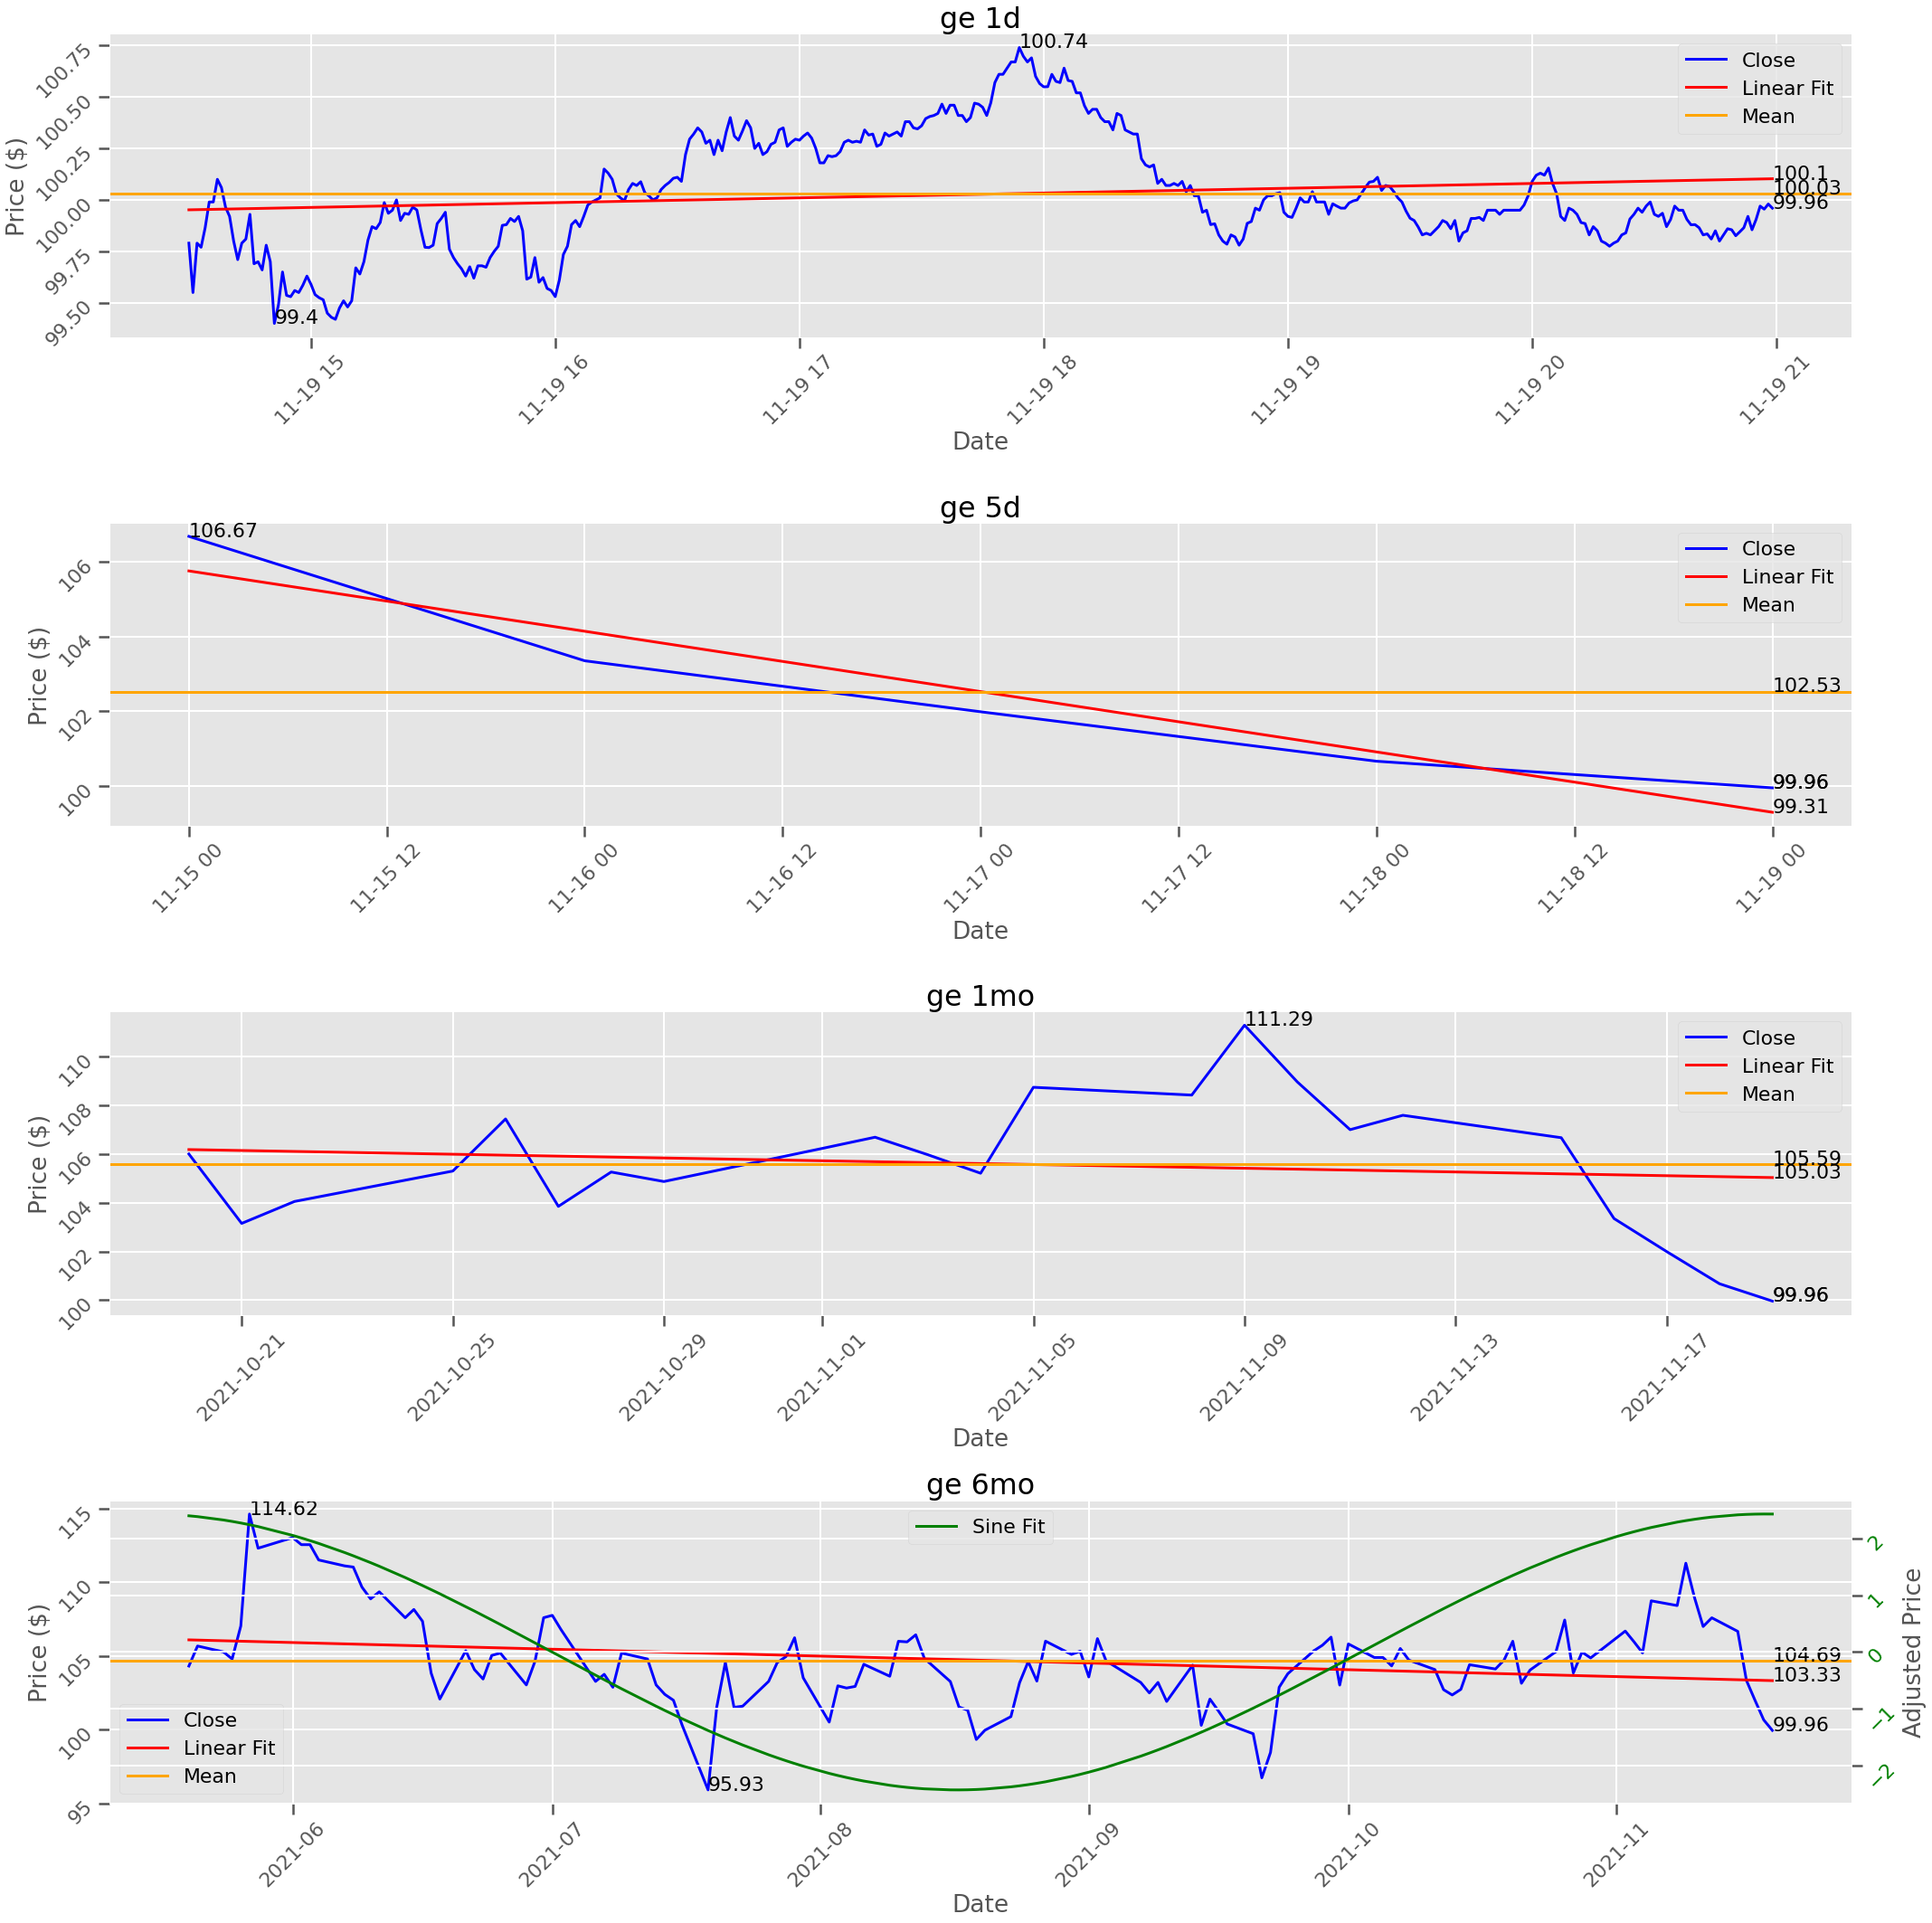

In [272]:
stock_dic = get_stock('ge')
for i, key in enumerate(stock_dic.keys()):
    if i > 0:
        stock_dic[key] = get_fits(stock_dic[key], key)
val_df = get_values(stock_dic)
analysis(stock_dic, val_df)
graph(stock_dic, val_df)